In [27]:
%matplotlib widget
import pandas as pd
import matplotlib.pyplot as plt


In [28]:
# Read both of the tables
df_1 = pd.read_csv('./CatoPDF_Spring2022_LORD.csv.dat', skiprows=6, delimiter='\t', usecols=range(0,9))
df_2 = pd.read_csv('./CatoPDF_Spring2022_LORD.csv.dat', skiprows=6, delimiter='\t', usecols=range(9,18))
# df_1 = pd.read_csv('./Airbrakes_Spring2023_LORD.csv.dat', skiprows=6, delimiter='\t', usecols=range(0,9))
# df_2 = pd.read_csv('./Airbrakes_Spring2023_LORD.csv.dat', skiprows=6, delimiter='\t', usecols=range(9,18))

In [29]:
# Merge the dataframes
df_m = pd.merge(df_1, df_2.rename(columns={'time.1':'time'}), on='time',  how='left')

# Interpolate missing values (since we merged on different sized tables
df_m.set_index('time', inplace=True)
#df_m.interpolate(method='index', inplace=True)
df_m.bfill(inplace=True)
df_m.reset_index(inplace=True)

# Constrain time to range we care about observing
tstart = 1450 #1461.25
tend = 1500.5#1550 #1472.5
df_m = df_m[(df_m['time'] < tend) & (df_m['time'] > tstart)]

# Visually check that things look like
print(df_m.head())

              time   accel_x   accel_y   accel_z    gyro_x    gyro_y  \
62298  1450.000977  0.118013  0.045976 -9.785261 -0.480377  0.419746   
62299  1450.001953  0.111720  0.076803 -9.747754 -0.743052  0.197038   
62300  1450.003052  0.091082  0.129472 -9.762688 -0.816527  0.232145   
62301  1450.004028  0.090294  0.173115 -9.784898 -0.853695  0.216455   
62302  1450.005005  0.096537  0.210535 -9.791042 -0.835746  0.396840   

         gyro_z  gps  gps.1   altitude  estLinearAccelX  estLinearAccelY  \
62298  0.298899  0.0    4.0  35.718876        -0.297267        -0.124500   
62299  0.486555  0.0    4.0  35.718876        -0.297267        -0.124500   
62300  0.363688  0.0    4.0  35.718876        -0.318604        -0.048872   
62301  0.287782  0.0    4.0  35.718876        -0.318604        -0.048872   
62302  0.254113  0.0    4.0  35.718876        -0.343310         0.049632   

       estLinearAccelZ      roll     pitch       yaw  gps.2  
62298        -0.044540 -0.013491  0.043674  1.47

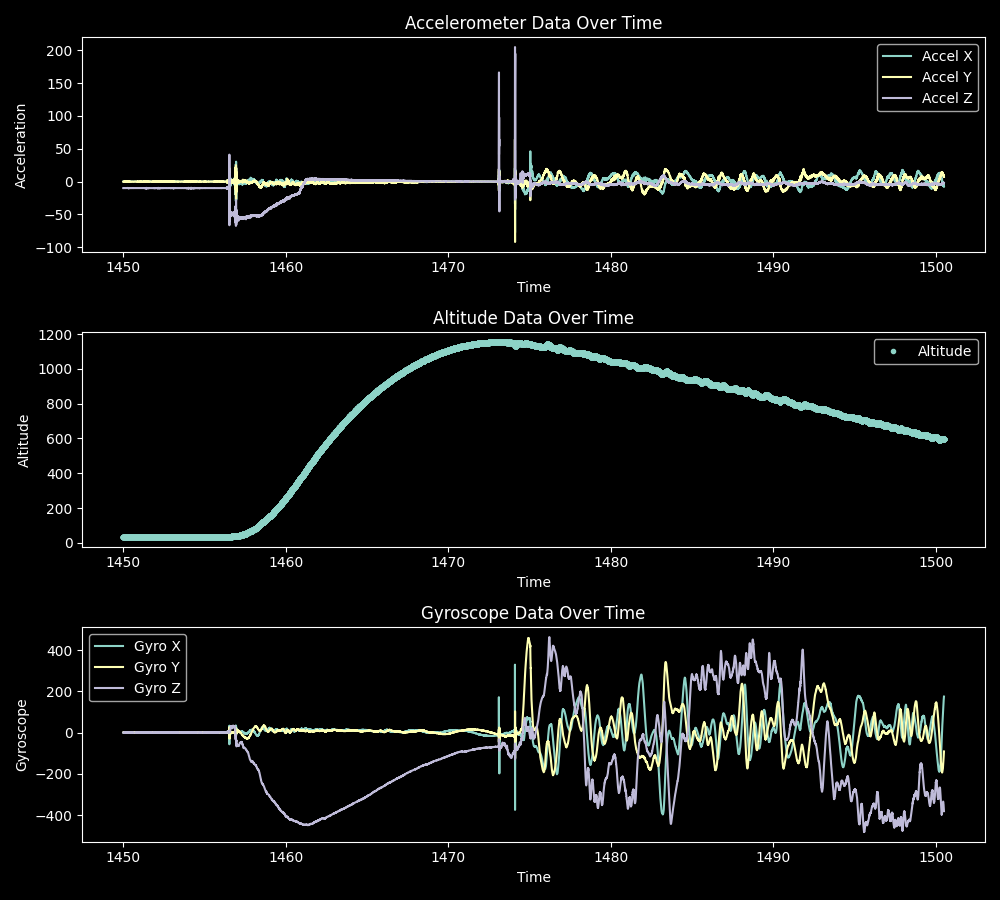

In [30]:
# Plot accelerometer data
plt.figure(figsize=(10, 9))
plt.subplot(3, 1, 1)
plt.plot(df_m['time'], df_m['accel_x'], label='Accel X')
plt.plot(df_m['time'], df_m['accel_y'], label='Accel Y')
plt.plot(df_m['time'], df_m['accel_z'], label='Accel Z')
plt.xlabel('Time')
plt.ylabel('Acceleration')
plt.legend()
plt.title('Accelerometer Data Over Time')

# Plot Altitude data
plt.subplot(3, 1, 2)
plt.plot(df_m['time'], df_m['altitude'], '.', label='Altitude')
plt.xlabel('Time')
plt.ylabel('Altitude')
plt.legend()
plt.title('Altitude Data Over Time')

# Plot gyroscope data
plt.subplot(3, 1, 3)
plt.plot(df_m['time'], df_m['gyro_x'], label='Gyro X')
plt.plot(df_m['time'], df_m['gyro_y'], label='Gyro Y')
plt.plot(df_m['time'], df_m['gyro_z'], label='Gyro Z')
plt.xlabel('Time')
plt.ylabel('Gyroscope')
plt.legend()
plt.title('Gyroscope Data Over Time')

# Show the plot
plt.tight_layout()
plt.show()

In [31]:
import filterpy.kalman as kf
from filterpy.kalman import KalmanFilter
import numpy as np
from scipy.linalg import block_diag
from filterpy.common import Q_discrete_white_noise
from scipy.signal import butter, lfilter, freqz
import scipy


In [32]:
time_series = df_m['time']
altitude_series = df_m['altitude']

In [33]:
altitude_data = altitude_series.to_numpy()
time_data = time_series.to_numpy()

# def make_cv_filter(dt, std, variance):
#     cvfilter = KalmanFilter(dim_x = 2, dim_z=1)
#     cvfilter.x = np.array([0., 0.])
#     cvfilter.P *= 3
#     cvfilter.R *= std**2
#     cvfilter.F = np.array([[1, dt],
#                            [0,  1]], dtype=float)
#     cvfilter.H = np.array([[1, 0]], dtype=float)
#     cvfilter.Q = Q_discrete_white_noise(dim=2, dt=dt, var=variance)
#     return cvfilter

def FirstOrderKF(R, Q, dt):
    """ Create first order Kalman filter. 
    Specify R and Q as floats."""
    
    kf = KalmanFilter(dim_x=2, dim_z=1)
    kf.x = np.zeros(2)
    kf.P *= np.array([[100, 0], [0, 1]])
    kf.R *= R
    kf.Q = Q_discrete_white_noise(2, dt, Q)
    kf.F = np.array([[1., dt],
                     [0., 1]])
    kf.H = np.array([[1., 0]])
    return kf


burnin = 30

R, Q = 0.02, 0.08

tracker = FirstOrderKF(R, Q, dt=1)

tracker.alpha = 1.0005

current_time_index = 0
dt = 1

time_values = []
pos_estimates = []
vel_estimates = []

apogee_estimates = []

gravity_accel = -9.81 # m/s per second
apogee_multiplier = 1.5

def getApogeeEstimate(current_alt, current_velocity):
    # trajectory formula
    # a(x**2) + bx + c
    # (0.5 * gravity_accel)(x**2) + (velo)x + (current_alt)
    # where x is time
    
    a = (0.5 * gravity_accel) * apogee_multiplier
    b = current_velocity
    c = current_alt
    
    # get vertex X (-b/2a)
    vertex_x = (-b) / (2 * a)
    
    # return the y-value at that location
    return (a * (vertex_x**2)) + (b * vertex_x) + c


for index, value in enumerate(time_data):
    if (index > 0):
        dt = value - time_data[index-1]

    tracker.F = np.array([[1., dt],
                          [0., 1]])
    
    tracker.Q = Q_discrete_white_noise(2, dt, Q)
    
    tracker.predict()
    tracker.update(altitude_data[index])
    
    time_values.append(value)
    pos_estimates.append(tracker.x[0])
    vel_estimates.append(tracker.x[1])
    
    current_apogee_est = getApogeeEstimate(tracker.x[0], tracker.x[1])
    apogee_estimates.append(current_apogee_est)
    
    

Text(0.5, 1.0, 'Deriv_Altitude Data Over Time')

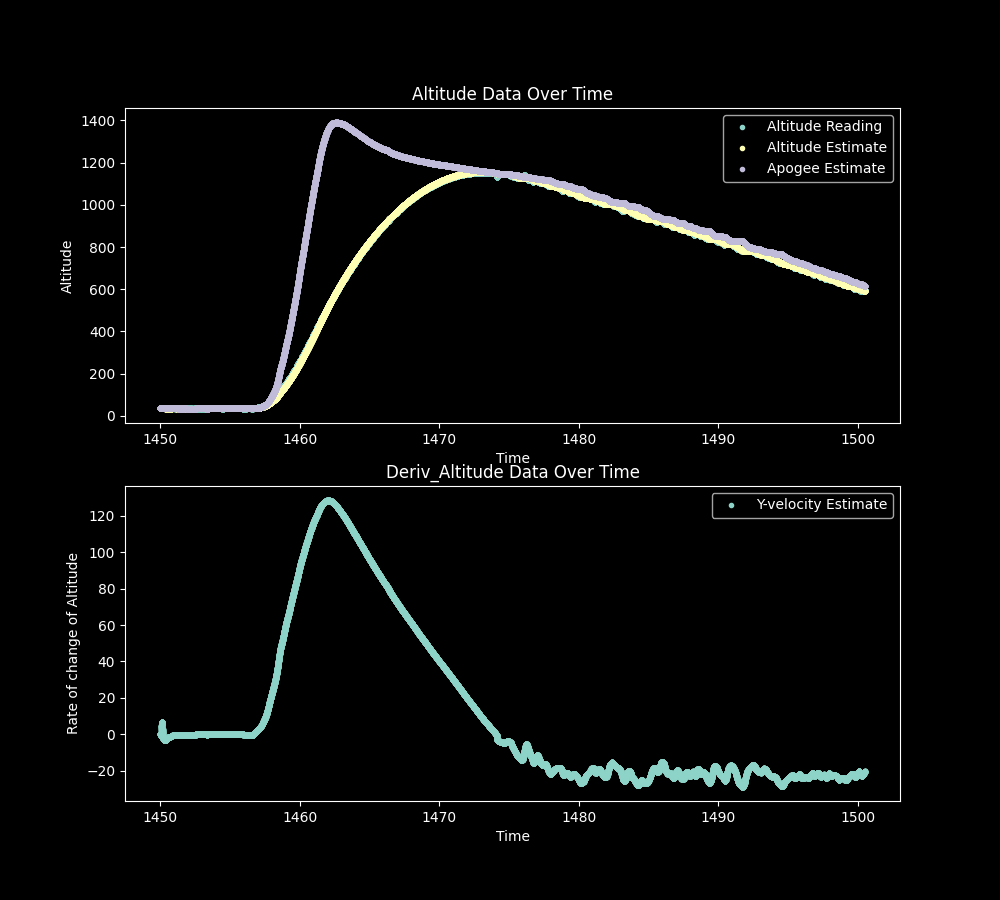

In [34]:
plt.figure(figsize=(10, 9))
plt.subplot(2, 1, 1)
plt.plot(time_series, altitude_data, '.', label='Altitude Reading')
plt.plot(time_values, pos_estimates, '.',  label='Altitude Estimate')
plt.plot(time_values, apogee_estimates, '.',  label='Apogee Estimate')
plt.xlabel('Time')
plt.ylabel('Altitude')
plt.legend()
plt.title('Altitude Data Over Time')


plt.subplot(2, 1, 2)

#plt.plot(time_series, d_altitude_series, label='Altitude Derivative')
plt.plot(time_values, vel_estimates, '.', label='Y-velocity Estimate')
plt.xlabel('Time')
plt.ylabel('Rate of change of Altitude')
plt.legend()
plt.title('Deriv_Altitude Data Over Time')
